Andrew Wolf

April 28, 2018

Capstone Guideline: https://github.com/udacity/machine-learning/blob/master/projects/capstone/capstone_report_template.md

# I. Definition

## Project Overview

Kaggle facilitated a data science competition in 2018 where the fields of computer vision and medical research intersect, meeting the need for algorithms that automatically detect nuclei in divergent microsopy images. To generate new medical treatments for human diseases, researchers have to measure the effects of these treatments on various human cells. To measure these effects, an initial step is to detect the total number of cellular nuclei of stained cells in microscopy images from various experimental conditions. Nuclei are the control centers of human cells containing the DNA which provides the blueprint of the intracellular activities of the host cell. Staining the cells such that the nuclei are visible provides the most distinct, effective detection compared to other staining methods. Accurate detection of these nuclei allows research scientists to identify the individual cells which necessarily precedes measuring drug or treatment effects on these cells. Manually detecting the thousands of individual nuclei consumes excessive time and naturally incurs human detection error while computers are better designed to count large amounts of data. The purpose of the 2018 Data Science Bowl[1] Kaggle competition and goal of my capstone project is to construct an algorithm that automatically detects these nuclei with optimal speed and accuracy.

Several others tackled similar problems in various domains. 

In [2] a UNet was constructed for instance segmentation of neuronal structures and various stained cells in microscopy images, a dataset very similar to the Kaggle dataset. A U-Net is a fully convolutional neural network, a neural network that has only convolutional and pooling layers, with no fully connected layers. From data augmentations of elastic deformations, shifts, and rotations this model has high invariance and robustness. The elastic deformations mainly allow this model to generalize well to divergent biomedical microsopy images. 
The U-Net architecture is defined by a 'contracting' or downsampling path that kees the contexts of the input images followed by an 'expanding' or upsampling path that captures the positions or localizations of parts of the input images.

In [3] the authors proposed Mask RCNN for instance segmenation. [4] proposed a Path Aggregation Network (PANet) based on the Mask RCNN. IN addition to the FPN, the authors of PANet added bottom-up augmentation, adaptive feature pooling, and fully-connected fusion to improve the predecessor Mask RCNN.


## Problem Statement & History

This is an instance segmentation problem, which combines both object detection and semantic segmentation. The purpose of the Kaggle competion is to automatically detect the correct number of nuclei in each image generated from a microscope of stained cells, presenting the object detection aspect. It is wise to also capture a pixel-wise mask of each nucleus that identifies the class (nucleus vs. background) and separates each nucleus into a unique instance, providing more granular semantic segmenation. From the precise shape of each nucleus captured by this advanced segmentation would also allow identification of cell types for use beyond detection. The metric (a standard for several object detection Kaggle competitions) to measure the solution is mean average precision (mAP) which is detailed in the 'Metrics' subsection. The model must distinguish each instance against the background, hence a part of the solution includes binary classification between the two classes of ‘nuclei’ and ‘background’.


## Metrics

# II. Analysis

## Data Exploration

The first question to guide the exploratory data analysis (EDA) on this dataset.
(1) How many types of images in the default stage 1 training and test sets? 
We can use the K-Means algorithm can answer this question. 

In [2]:
#inspired by the Kaggle kernel from Jack Vial: https://www.kaggle.com/jackvial/exploratory-data-analysis-dsb-2018
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from glob import glob 
from tqdm import tqdm
from skimage.io import imread, imshow
import os
import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots as splt
import seaborn as sns
from sklearn.cluster import KMeans as km

TRAIN_PATH = 'train_images/'

train_ids = os.listdir(TRAIN_PATH)

In [3]:
#empty lists to contain the images and masks of Kaggle stage 1 training set
images = []
masks = []

#empty lists to contain the descriptive statistics (metadata) about the images and masks 
img_meta = []
mask_meta = []

for id_ in train_ids:
    path = TRAIN_PATH + id_ 
    image = cv2.imread(path + '/images/' + id_ + '.png')
    images.append(image)
    img_height = image.shape[0]
    img_width = image.shape[1]
    img_area = img_height * img_width
    
    
    nuc_count = 1 #initializes counting for the nuclei, only one nucleus in each mask 
    for file in os.listdir(path + '/masks/'):
        mask = cv2.imread(path + '/masks/' + file)
        masks.append(mask)
        mask_height = mask.shape[0]
        mask_width = mask.shape[1]
        mask_area = mask_height * mask_width
        
        
        #finds the area of each nucleus by summing up all pixel values (only 0, or 255) and dividing by 255
        #this finds the total number of pixels composing the nucleus, which is the area
        nuc_area = (np.sum(mask))/255
        
        nuc_img_ratio = nuc_area/mask_area
        
        nuc_count += 1
        
        mask_meta.append([mask_height, mask_width, mask_area, nuc_area, nuc_img_ratio])#adding all metadata to empty mask_meta list
    img_meta.append([img_height, img_width, img_area, nuc_count])#adds all metadata to empty image_meta list

In [4]:
print('Total number of images in training set:',len(images))
print('')
print('Total number of nuclei:', len(masks))#there is one nucleus per mask, so the number of masks = number of nuclei 

Total number of images in training set: 670

Total number of nuclei: 29461


In [5]:
#formats the image metadata into a pandas dataframe 
df_img = df(img_meta, columns = ['image height', 'image width', 'image area', 'nuclei count'])

#computes descriptive statistics on the image metadata pandas dataframe
df_img.describe().loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]

,image height,image width,image area,nuclei count
mean,333.991045,378.500000,1.547583e+05,44.971642
std,149.474845,204.838693,1.908250e+05,47.962530
min,256.000000,256.000000,6.553600e+04,2.000000
25%,256.000000,256.000000,6.553600e+04,16.250000
50%,256.000000,320.000000,8.192000e+04,28.000000
75%,360.000000,360.000000,1.296000e+05,55.000000
max,1040.000000,1388.000000,1.443520e+06,376.000000


In [6]:
df_mask = df(mask_meta, columns = ['mask height', 'mask width', 'mask area', 'nucleus area', 'nucleus-image ratio'])

#mask descriptive statistics in pandas dataframe format
df_mask.describe().loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]

,mask height,mask width,mask area,nucleus area,nucleus-image ratio
mean,404.408642,506.068090,2.511955e+05,1415.411120,0.009496
std,187.400013,282.185678,2.516759e+05,1751.511121,0.013465
min,256.000000,256.000000,6.553600e+04,63.000000,0.000060
25%,256.000000,256.000000,6.553600e+04,354.000000,0.002976
50%,360.000000,360.000000,1.296000e+05,915.000000,0.005173
75%,520.000000,696.000000,3.619200e+05,1722.000000,0.010129
max,1040.000000,1388.000000,1.443520e+06,33111.000000,0.250671


In [7]:
df_img

,image height,image width,image area,nuclei count
0,256,256,65536,28
1,256,256,65536,37
2,256,320,81920,71
3,256,320,81920,87
4,256,320,81920,8
5,256,256,65536,17
6,256,256,65536,63
7,360,360,129600,24
8,256,256,65536,17
9,360,360,129600,23


In [11]:
df_mask

,mask height,mask width,mask area,nucleus area,nucleus-image ratio
0,520,696,361920,1497.0,0.004136
1,520,696,361920,729.0,0.002014
2,520,696,361920,1932.0,0.005338
3,520,696,361920,1863.0,0.005148
4,520,696,361920,279.0,0.000771
5,520,696,361920,144.0,0.000398
6,520,696,361920,627.0,0.001732
7,520,696,361920,504.0,0.001393
8,520,696,361920,1248.0,0.003448
9,520,696,361920,1530.0,0.004227


In [12]:
#this kmeans implementation is inspired by this code: https://stackoverflow.com/questions/40752088/extract-images-from-clusters-separately-in-kmeans-python
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline 
import sys
import pickle
import sklearn
from sklearn.externals import joblib
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os 
from skimage.feature import local_binary_pattern 
# To calculate a normalized histogram
from scipy.stats import itemfreq 
from sklearn.preprocessing import normalize 
import cvutils 
import csv 
import numpy 
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.cluster import KMeans

In [13]:
X_paths = []
X_test = []

for id_ in train_ids:
    train_paths = TRAIN_PATH + id_ + '/images/' + id_ + '.png'
    # Read the image using cv2 package
    im = cv2.imread(train_paths)
    # Convert to grayscale as Local Binary Pattern (LBP) works on grayscale image
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    radius = 3
    # Number of points to be considered as neighbors 
    neighbor_points = 7 * radius

    # Uniform LBP is used
    lbp = local_binary_pattern(im_gray, neighbor_points, radius, method='uniform')

    # Calculate the histogram
    x = itemfreq(lbp.ravel())


    # Normalize the histogram
    hist = x[:, 1]/sum(x[:, 1])


    # Append image path in X_paths
    X_paths.append(train_paths)

    # Append histogram to X_test
    X_test.append(hist)

joblib.dump((X_paths, X_test), 'lbp.pkl', compress=3)

X_test = np.array(X_test)

pca = PCA(n_components = 16)
pca.fit(X_test)
pca_activations = pca.transform(X_test)

X = np.array(pca_activations)
tsne = TSNE(n_components=2, learning_rate=500, perplexity=50, verbose=2, early_exaggeration=10.0).fit_transform(X)

tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 664 samples in 0.001s...
[t-SNE] Computed neighbors for 664 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 664 / 664
[t-SNE] Mean sigma: 0.029760
[t-SNE] Computed conditional probabilities in 0.100s
[t-SNE] Iteration 50: error = 45.9438858, gradient norm = 0.2936202 (50 iterations in 0.772s)
[t-SNE] Iteration 100: error = 45.0502396, gradient norm = 0.2949422 (50 iterations in 0.775s)
[t-SNE] Iteration 150: error = 44.4061737, gradient norm = 0.3049959 (50 iterations in 0.779s)
[t-SNE] Iteration 200: error = 45.3783493, gradient norm = 0.2945703 (50 iterations in 0.774s)
[t-SNE] Iteration 250: error = 45.7204971, gradient norm = 0.2854961 (50 iterations in 0.778s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.720497
[t-SNE] Iteration 300: error = 0.2716568, gradient norm = 0.0016059 (50 iterations in 0.702s)
[t-SNE] Iteration 350: error = 0.2543274, gradient norm = 0.0003084 

## Exploratory Visualization

In [ ]:
import random
r = random.randint(1,664)
imshow(images[r])
plt.show
print('')
print(images[r].shape)

In [ ]:
bin_values = np.arange(start = 0, stop = 1300, step = 20)
df_img[['image height', 'image width', 'nuclei count']].hist(bins=bin_values, figsize =[15,15])
plt.show()

In [ ]:
fig, ax = splt(nrows=1, ncols=4, figsize = (20, 10))
width_plt = sns.distplot(df_img['image width'].values, ax=ax[0])
width_plt.set(xlabel='width (px)')
width_plt.set(ylim=(0, 0.025))
height_plt = sns.distplot(df_img['image height'].values, ax=ax[1])
height_plt.set(xlabel='height (px)')
height_plt.set(ylim=(0, 0.03))
area_plt = sns.distplot(df_img['image area'].values, ax=ax[2])
area_plt.set(xlabel="area (px)")
nuclei_plt = sns.distplot(df_img['nuclei count'].values, ax=ax[3])
nuclei_plt.set(xlabel='nuclei count (px)')
fig.show()
plt.tight_layout()

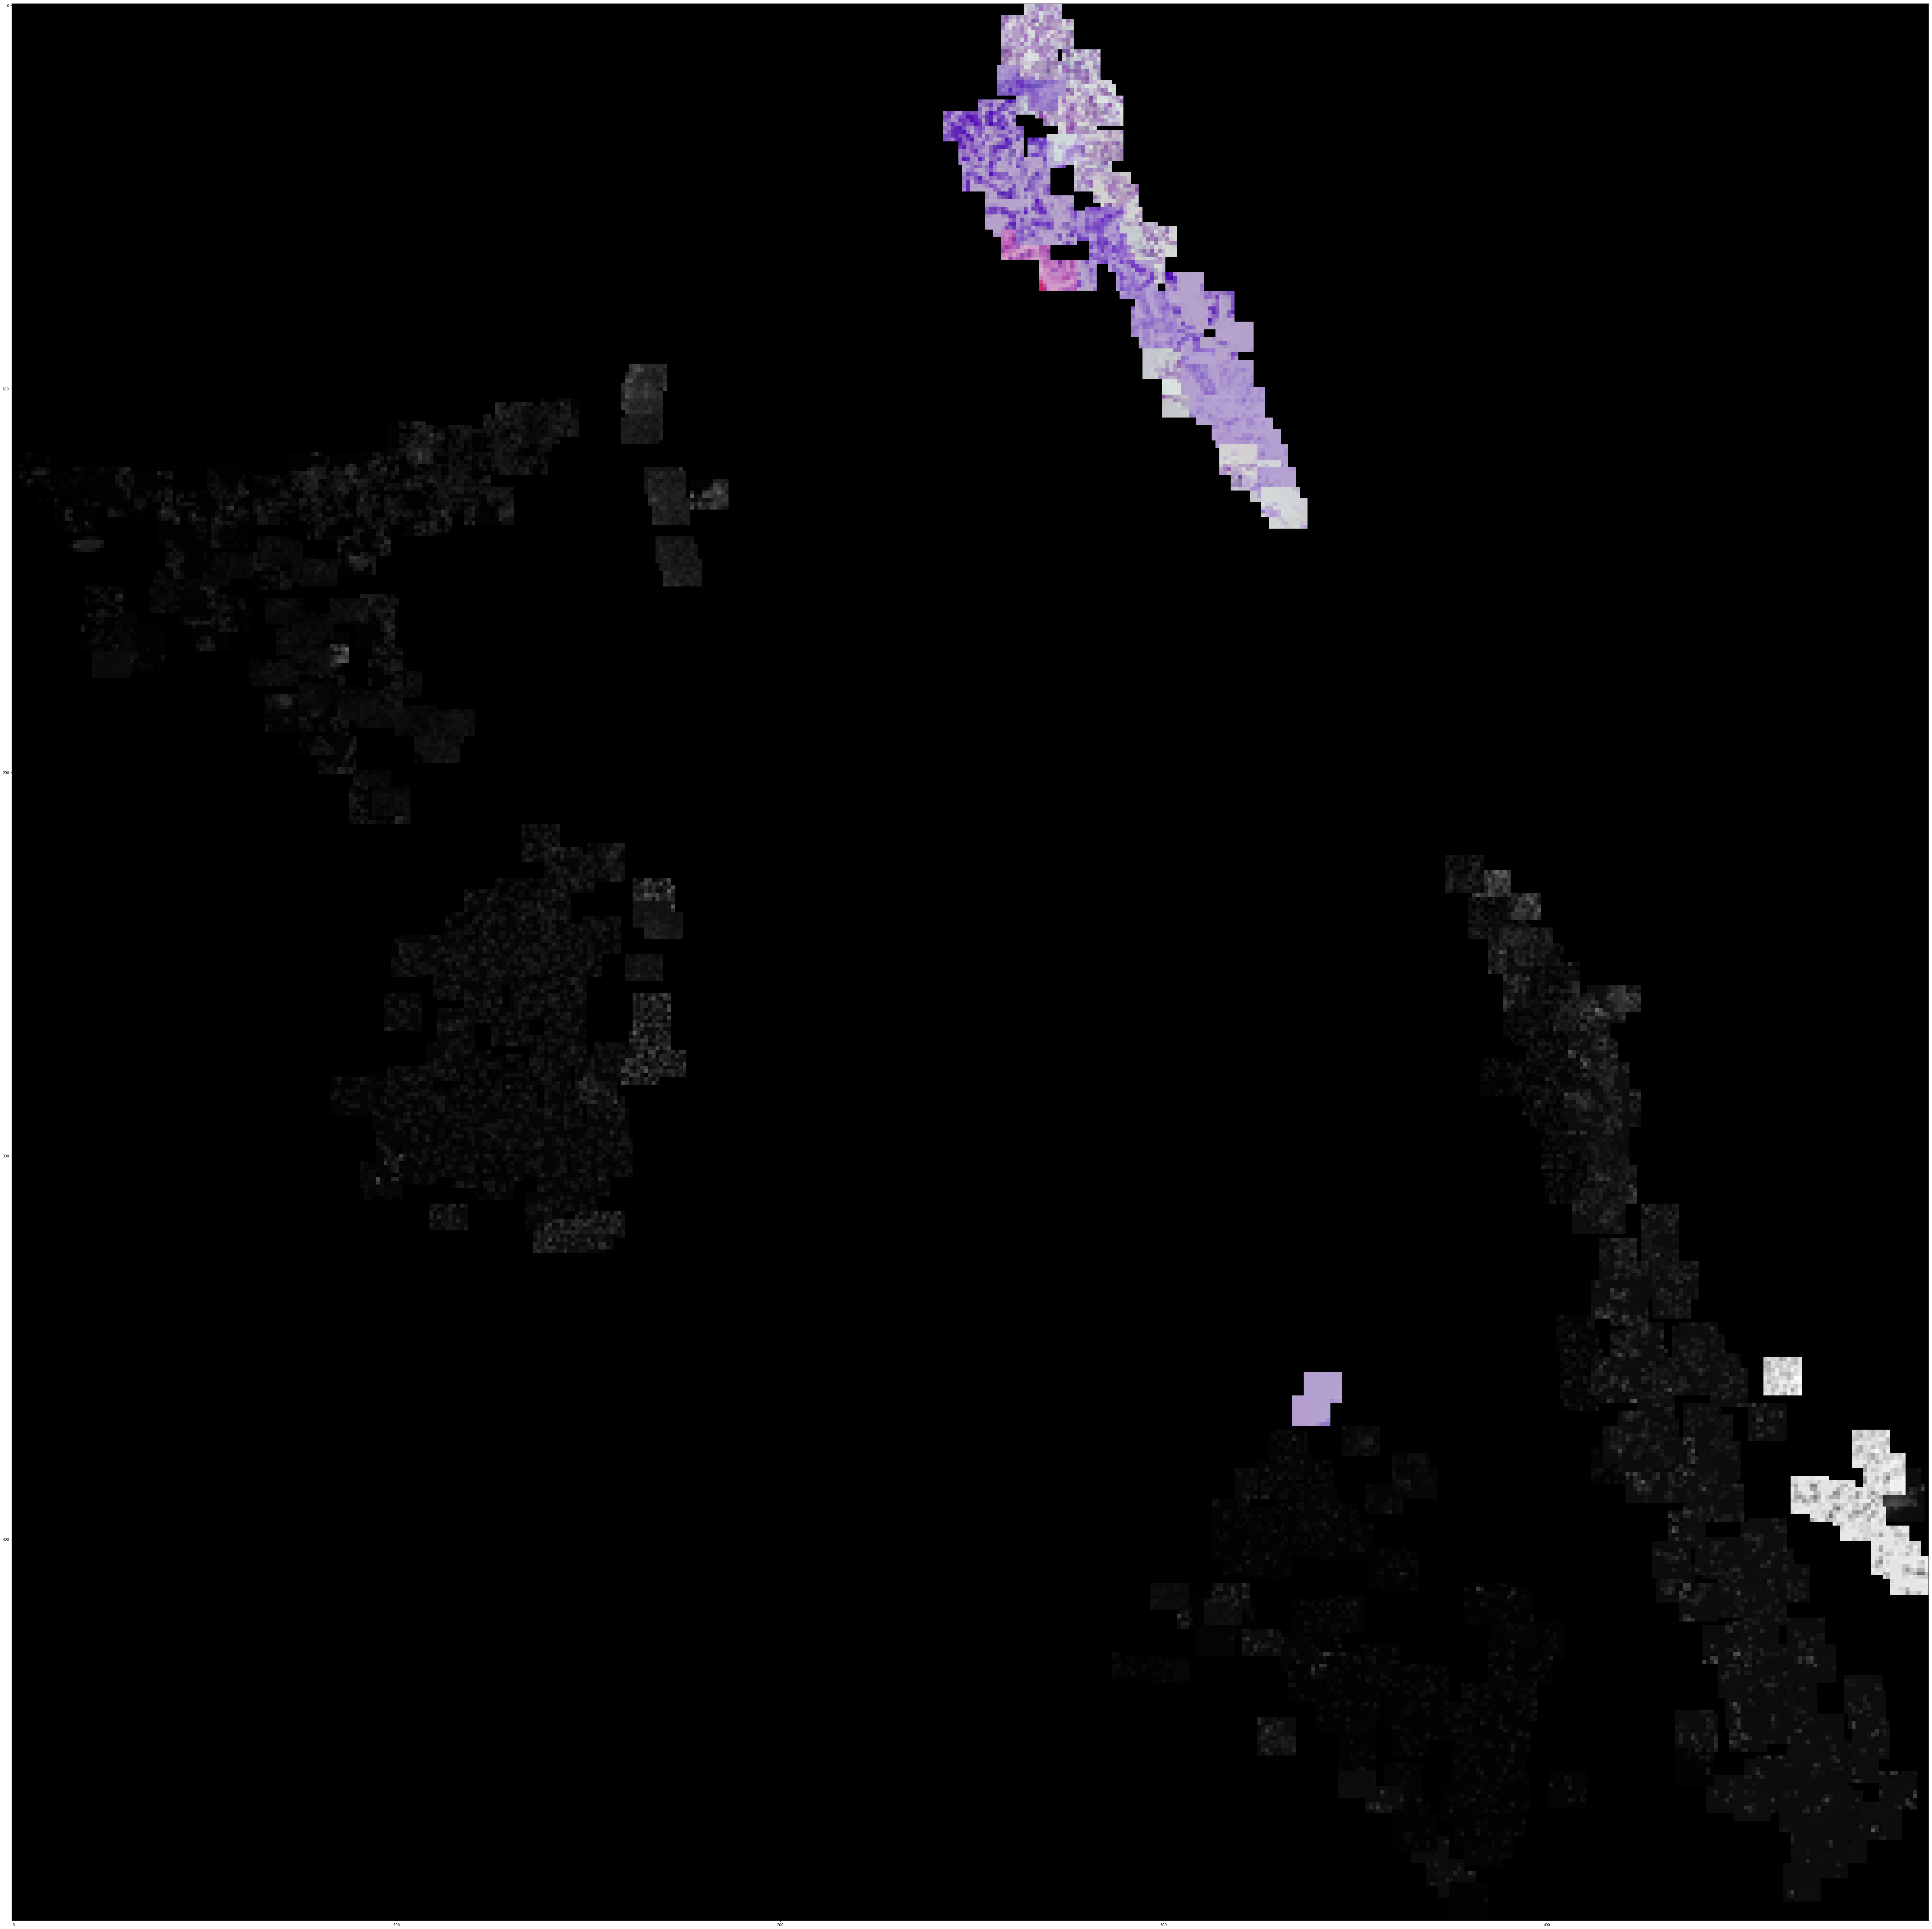

In [16]:
width = 500
height = 500
max_dim = 10

full_image = Image.new('RGB', (width, height))
for img, x, y in zip(X_paths, tx, ty):
    #print "for loop"
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)))
full_image.save("myTSNE.png")

matplotlib.pyplot.figure(figsize = (100,100))
plt.imshow(full_image)

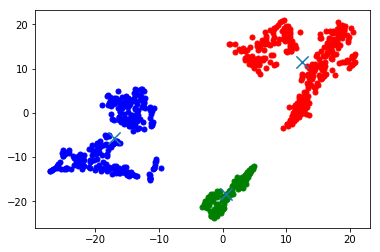

In [17]:
#Convert Images to Float32 
images = np.asarray(tsne, np.float32)
N = len(images)
images = images.reshape(N,-1)

#using kmeans clustring having 3 clusters
kmeans = KMeans(n_clusters=3)

#passing images to kmeans 
kmeans.fit(images)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

colors = 10*['r.','g.','b.','c.','k.','y.','m.']

for i in range(len(images)):
    plt.plot(images[i][0], images[i][1], colors[labels[i]], markersize = 10)

    img = cv2.convertScaleAbs(images[i])


plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=150, linewidths = 5, zorder = 20)

plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 664 samples in 0.001s...
[t-SNE] Computed neighbors for 664 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 664 / 664
[t-SNE] Mean sigma: 0.029760
[t-SNE] Computed conditional probabilities in 0.098s
[t-SNE] Iteration 50: error = 45.0335922, gradient norm = 0.3064944 (50 iterations in 0.770s)
[t-SNE] Iteration 100: error = 45.2623177, gradient norm = 0.2922547 (50 iterations in 0.790s)
[t-SNE] Iteration 150: error = 45.4092216, gradient norm = 0.2942174 (50 iterations in 0.784s)
[t-SNE] Iteration 200: error = 44.7732620, gradient norm = 0.3096150 (50 iterations in 0.782s)
[t-SNE] Iteration 250: error = 44.8702583, gradient norm = 0.2966105 (50 iterations in 0.783s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.870258
[t-SNE] Iteration 300: error = 0.2773409, gradient norm = 0.0010901 (50 iterations in 0.714s)
[t-SNE] Iteration 350: error = 0.2423188, gradient norm = 0.0006627 

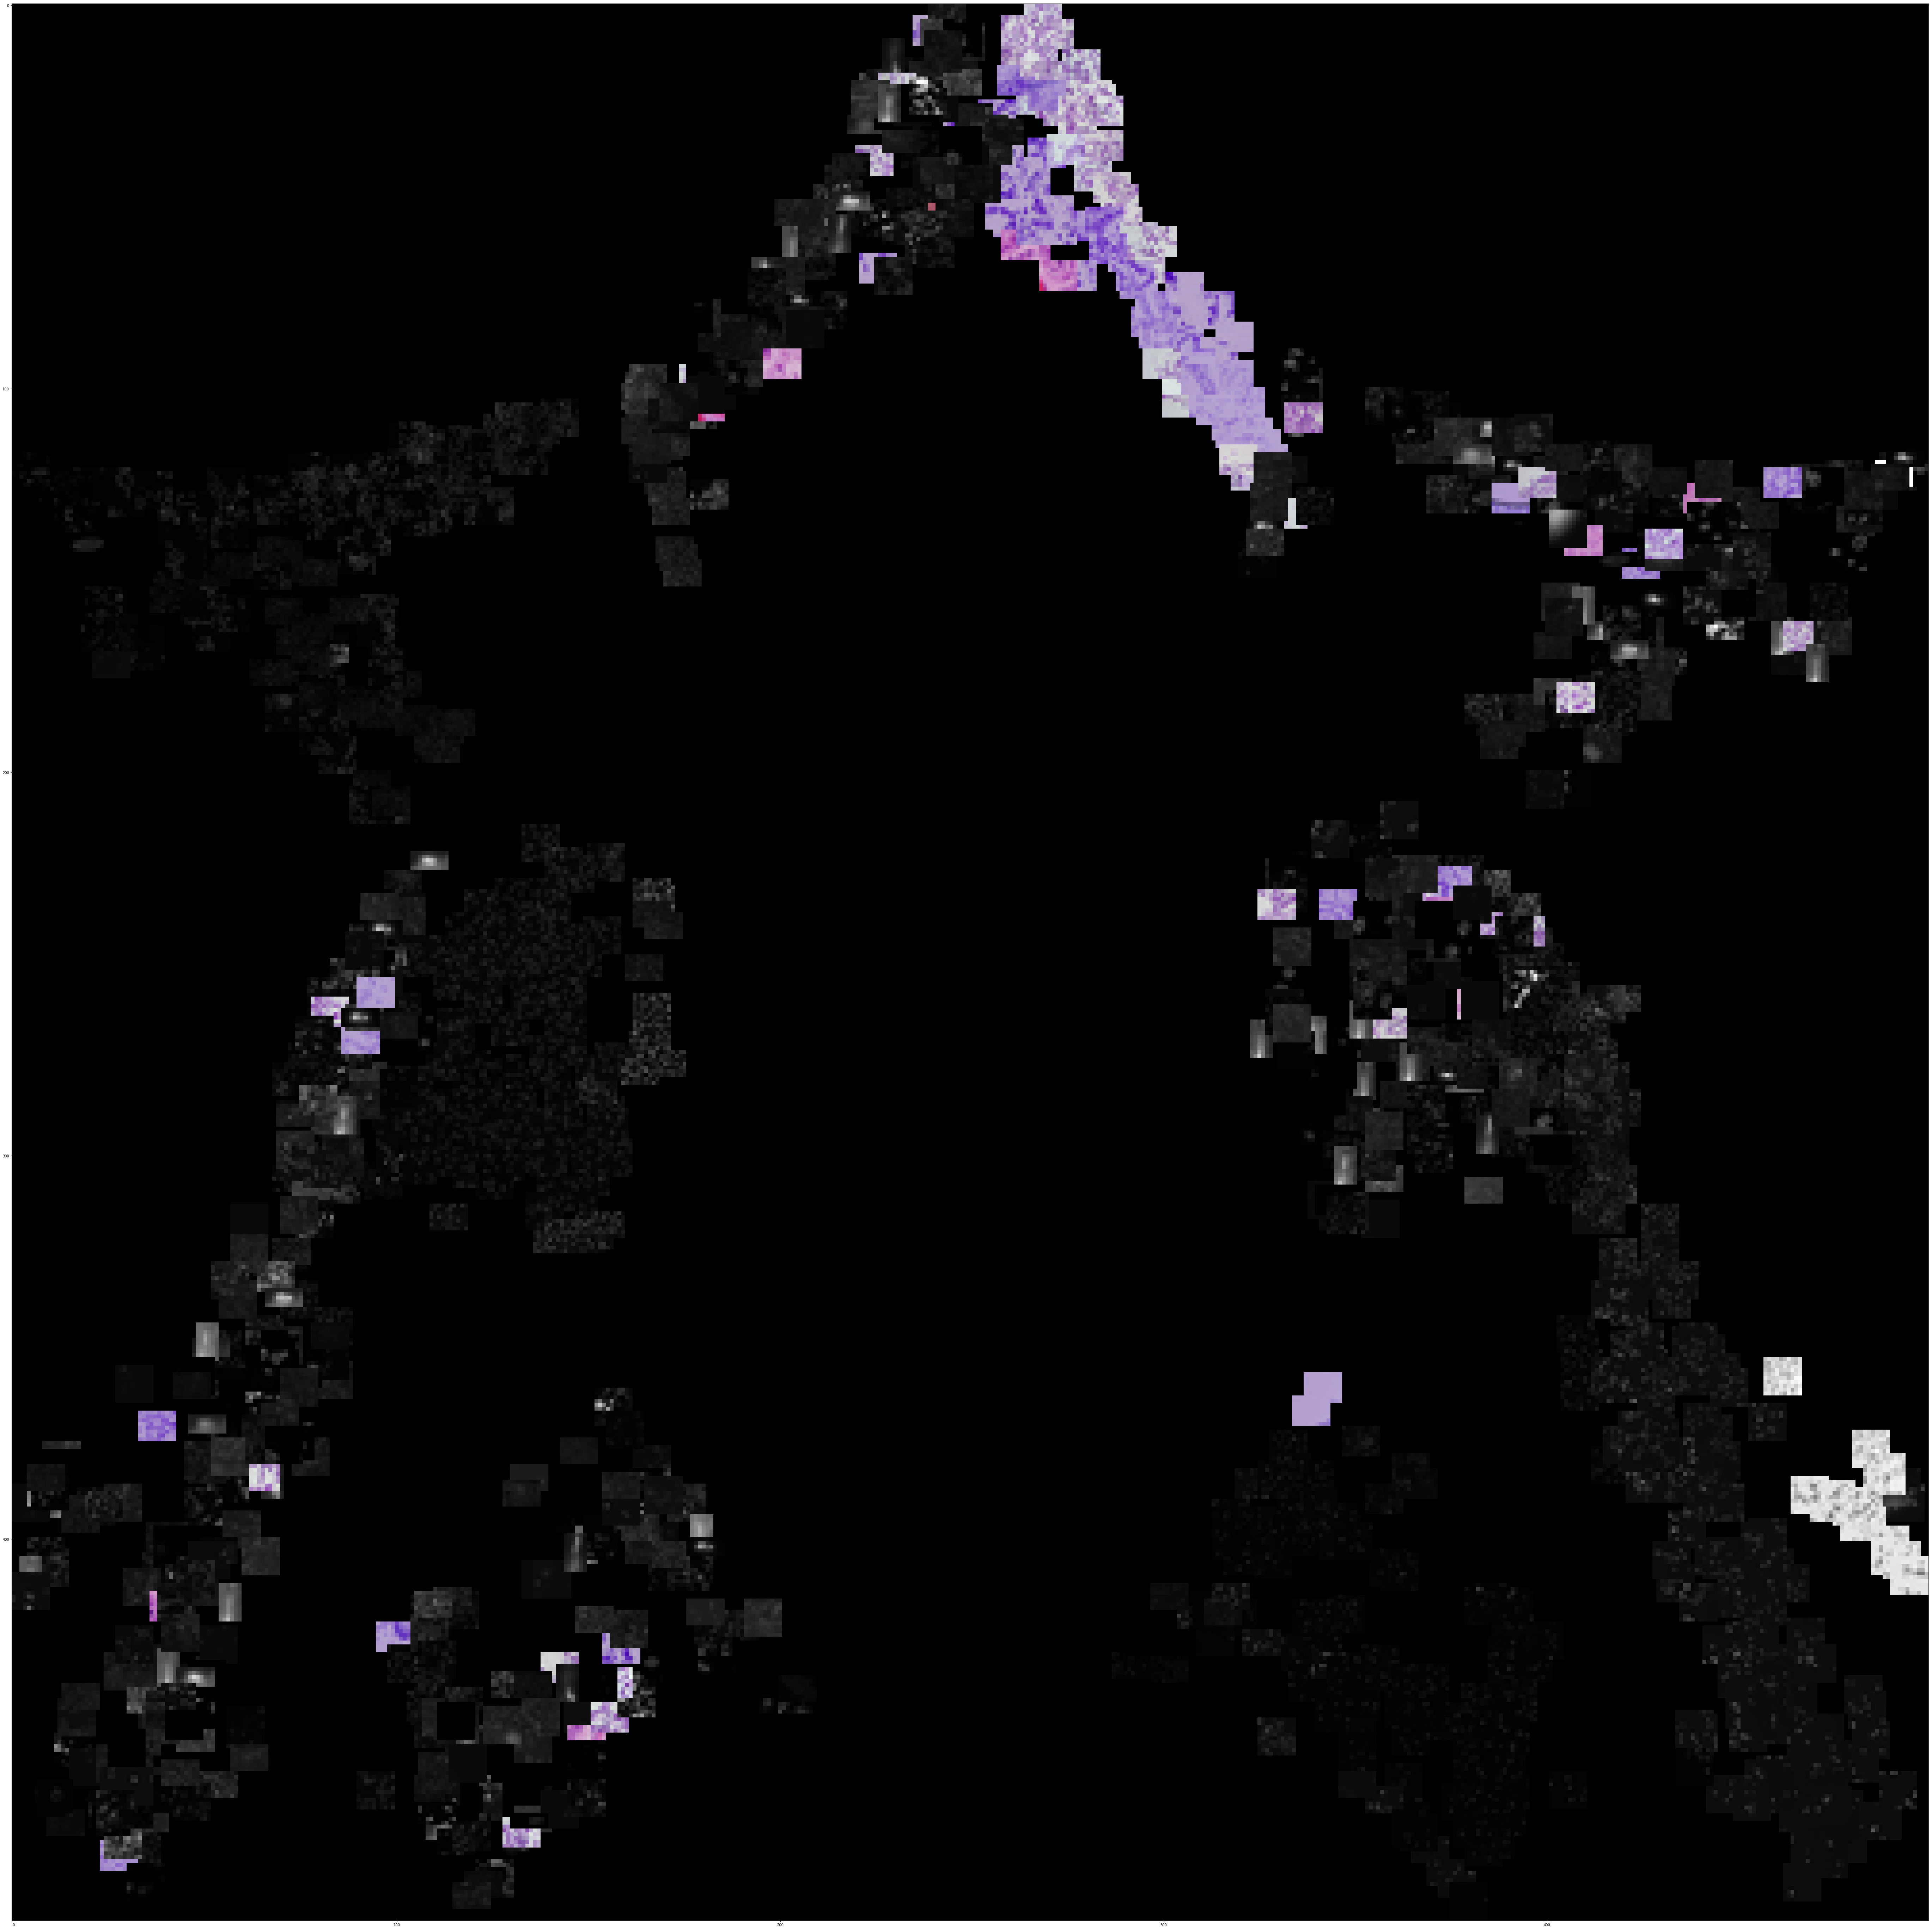

In [20]:
test_path = 'stage2_test/'
test_ids = os.listdir(test_path)
X2_paths = []
X2_test = []
for id_ in test_ids: 
    test_paths = test_path + id_ + '/images/' + id_ + '.png'
    cv2.imread(test_paths)
     # Convert to grayscale as Local Binary Pattern (LBP) works on grayscale image
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    radius = 3
    # Number of points to be considered as neighbors 
    neighbor_points = 7 * radius

    # Uniform LBP is used
    lbp = local_binary_pattern(im_gray, neighbor_points, radius, method='uniform')

    # Calculate the histogram
    x = itemfreq(lbp.ravel())


    # Normalize the histogram
    hist = x[:, 1]/sum(x[:, 1])


    # Append image path in X_paths
    X2_paths.append(test_paths)

    # Append histogram to X_test
    X2_test.append(hist)

joblib.dump((X2_paths, X2_test), 'lbp.pkl', compress=3)

X2_test = np.array(X_test)

pca = PCA(n_components = 16)
pca.fit(X2_test)
pca_activations = pca.transform(X2_test)

X2 = np.array(pca_activations)
tsne = TSNE(n_components=2, learning_rate=500, perplexity=50, verbose=2, early_exaggeration=10.0).fit_transform(X2)

tx2, ty2 = tsne[:,0], tsne[:,1]
tx2 = (tx2-np.min(tx2)) / (np.max(tx2) - np.min(tx2))
ty2 = (ty2-np.min(ty2)) / (np.max(ty2) - np.min(ty2))

width = 500
height = 500
max_dim = 10

full_image2 = Image.new('RGB', (width, height))
for img, x, y in zip(X2_paths, tx2, ty2):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)))
#full_image.save("myTSNE.png")

matplotlib.pyplot.figure(figsize = (100,100))
plt.imshow(full_image)

## Algorithsm & Techniques

## Benchmark

# III. Methodology

## Data Preprocessing

## Implementation

## Refinement

# IV. Results

## Model Evaluation & Validation

## Justification

## Conclusion

## References

Data Science Bowl Competition URL: https://www.kaggle.com/c/data-science-bowl-2018